In [1]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.base import clone
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score as ARI
from tqdm import tqdm  # for timing loops

from graspologic.embed import CovariateAssistedEmbedding as CASE
from graspologic.embed import LaplacianSpectralEmbed as LSE
from graspologic.simulations import sbm
from graspologic.plot import heatmap, pairplot

import sys
np.set_printoptions(threshold=sys.maxsize)
np.random.seed(42)


In [2]:


def gen_sbm(p, q, assortative=True, N=1500):
    if not assortative:
        p, q = q, p

    n = N//3
    A = np.full((3, 3), q)
    A[np.diag_indices_from(A)] = p
    return sbm([n, n, n], A, return_labels=True)


def gen_covariates(labels, m1, m2, d=3):
    """
    n x 3 matrix of covariates

    """
    n_total = len(labels)
    m2_array = np.random.choice([1, 0], p=[m2, 1-m2], size=(n_total, d))
    m1_array = np.random.choice([1, 0], p=[m1, 1-m1], size=n_total)
    m2_array[np.arange(n_total), labels] = m1_array
    return m2_array


def get_misclustering(A, model, labels, covariates=None):
    if covariates is None:
        Xhat = model.fit_transform(A)
    else:
        Xhat = model.fit_transform(A, covariates=covariates)

    kmeans = KMeans(n_clusters=3)
    labels_ = kmeans.fit_predict(Xhat)
    misclustering = 1 - ARI(labels, labels_)

    return misclustering


def trial(p=.03, q=.015, m1=.8, m2=.02, assortative=True) -> dict:
    """
    Return misclustering rates for all models under particular assumptions.

    """

    # set up models
    assrttv_model = CASE(assortative=True, n_components=3, normalize=True)
    non_assrttv_model = CASE(assortative=False, n_components=3, normalize=True)
    cca_model = None
    reg_LSE_model = LSE(n_components=3, form="R-DAD", normalize=True)
    cov_LSE_model = clone(reg_LSE_model)
    casc_models = {"assortative": assrttv_model,
                   "non_assortative": non_assrttv_model,
                   "LSE": reg_LSE_model,
                   "Covariance LSE": cov_LSE_model}

    # generate data
    A, labels = gen_sbm(p, q, assortative=assortative)
    X = gen_covariates(labels, m1, m2)

    # fit, cluster, get misclustering rates
    misclusterings = {}
    for name, model in casc_models.items():
        if name in {"assortative", "non_assortative"}:
            misclustering = get_misclustering(A, model, labels, covariates=X)
        elif name == "LSE":
            misclustering = get_misclustering(A, model, labels)
        # elif name == "Covariance LSE":
        #     misclustering = get_misclustering(np.cov(X), model, labels)

        misclusterings[name] = misclustering

    # return misclustering rates
    return misclusterings


def trials(p=.03, q=.015, m1=.8, m2=.02, trial_type="", assortative=True):
    """
    vary within-minus between-block probability (p-q)
    """
    num_trials = 6
    print(trial_type)
    if trial_type == "probability":
        max_diff = .025
        x, y = p, q
    elif trial_type == "covariate":
        max_diff = .6
        x, y = m1, m2
    else:
        raise ValueError("need trial_type")

    xs = np.full(num_trials, y)
    diffs = np.linspace(0, max_diff, num=num_trials)
    ys = xs + diffs
    probs = np.c_[xs, ys]

    results = np.zeros((num_trials, 5))
    results[:, 0] = diffs
    for i, (x, y) in tqdm(enumerate(probs)):
        # for i, (p, q) in enumerate(probs):
        if trial_type == "probability":
            misclusterings = trial(p=x, q=y, assortative=assortative)
        elif trial_type == "covariate":
            misclusterings = trial(m1=x, m2=y, assortative=assortative)
        for j, name in enumerate(misclusterings.keys()):
            j += 1  # to account for the p-q column
            results[i, j] = misclusterings[name]

    return results


# probability trials
assortative_prob = trials(trial_type="probability", assortative=True)
non_assortative_prob = trials(trial_type="probability", assortative=False)

# covariate trials
assortative_cov = trials(trial_type="covariate", assortative=True)
non_assortative_cov = trials(trial_type="covariate", assortative=False)


def plot_results(results, ax=None, xlabel="", title=""):
    if ax is None:
        ax = plt.gca()

    x, assortative, non_assortative, rlse, cov_lse = results.T
    ax.plot(x, assortative, 'k--')
    ax.plot(x, non_assortative, 'k-')
    ax.plot(x, rlse, 'k-.')

    ax.set_xlabel(xlabel)
    ax.set_ylabel("Average misclustering rate")
    ax.set_title(title)



0it [00:00, ?it/s]probability
6it [00:09,  1.51s/it]
0it [00:00, ?it/s]probability
6it [00:08,  1.44s/it]
0it [00:00, ?it/s]covariate
6it [00:09,  1.57s/it]
0it [00:00, ?it/s]covariate
6it [00:09,  1.52s/it]


Text(0.5, 0, 'Covariate to graph block membership agreement')

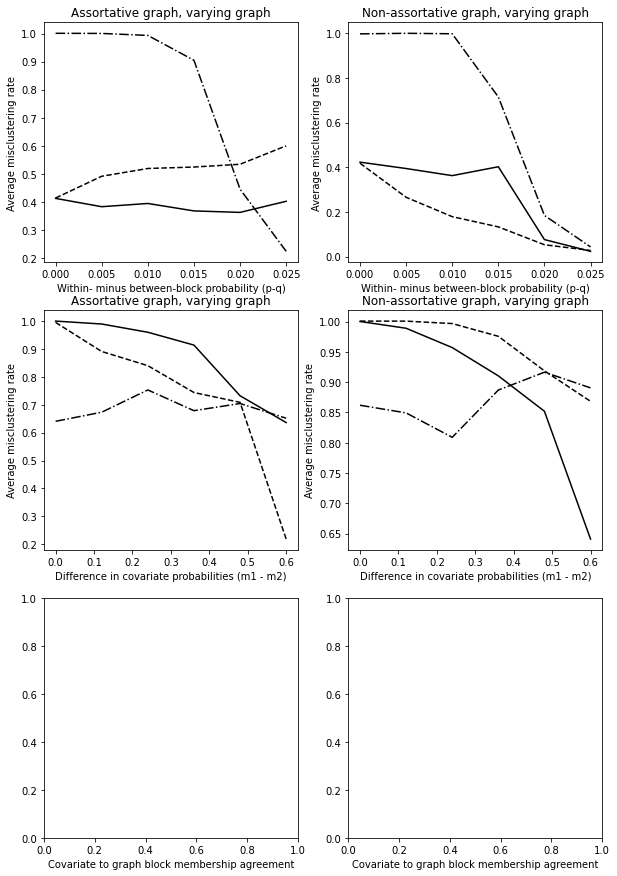

In [4]:
# make figure
fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(10, 15))
assortative_title = "Assortative graph, varying graph"
non_assortative_title = "Non-assortative graph, varying graph"

# plot probability trials
xlabel = "Within- minus between-block probability (p-q)"
plot_results(assortative_prob,
             ax=axs[0, 0], xlabel=xlabel, title=assortative_title)

plot_results(non_assortative_prob,
             ax=axs[0, 1], xlabel=xlabel, title=non_assortative_title)

# plot covariate trials
xlabel = "Difference in covariate probabilities (m1 - m2)"
plot_results(assortative_cov,
             ax=axs[1, 0], xlabel=xlabel, title=assortative_title)

plot_results(non_assortative_cov,
             ax=axs[1, 1], xlabel=xlabel, title=non_assortative_title)

xlabel = "Covariate to graph block membership agreement"
axs[2, 0].set_xlabel(xlabel)
axs[2, 1].set_xlabel(xlabel)
